## Traditional Methods

In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.feature import canny
from skimage.color import rgb2gray, label2rgb
from skimage.filters import sobel
from skimage.segmentation import watershed 
import scipy.ndimage as nd

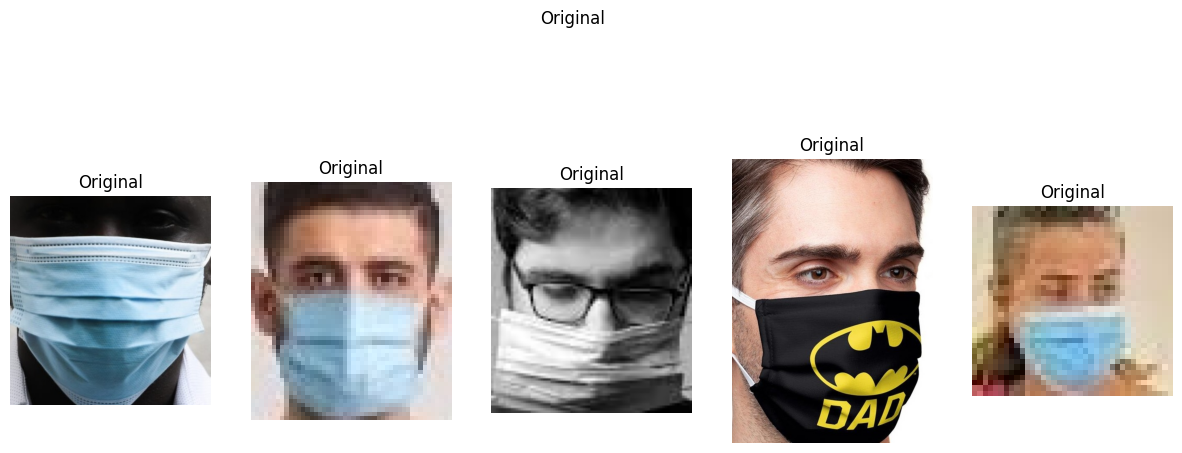

In [50]:

image_dir = "MSFD/1/face_crop/"
file_names = [f"{str(i).zfill(6)}_1.jpg" for i in range(5)]  # 000000_1.jpg to 000004_1.jpg

images = []
for file_name in file_names:
    image_path = os.path.join(image_dir, file_name)
    image = cv2.imread(image_path)
    if image is not None:
        images.append(image)
    else:
        print(f"Warning: Could not read {image_path}")



plt.figure(figsize=(15, 6))
for i, image in enumerate(images):
    image_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_2)
    plt.title("Original")
    plt.axis("off")
plt.suptitle("Original")
plt.show()



In [51]:
image_dir = "MSFD/1/face_crop/"
mask_dir = "MSFD/1/face_crop_segmentation/"

# IoU and Dice calculation functions
def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    return intersection / union if union != 0 else 0

def compute_dice(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    total_pixels = mask_pred.sum() + mask_gt.sum()
    return (2 * intersection) / total_pixels if total_pixels != 0 else 0

## Thresholding

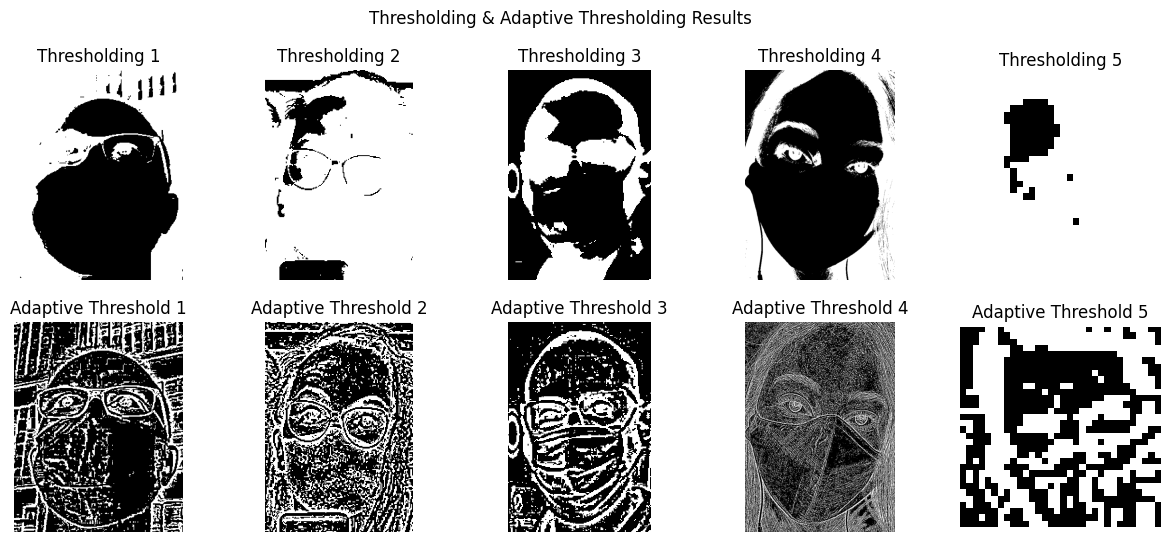

Average IoU: 0.1414
Average Dice: 0.0009


In [ ]:
# checking thresholding fro first few images
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")][:5]  # First 5 images

iou_scores = []
dice_scores = []

plt.figure(figsize=(15, 6))
for i, file_name in enumerate(image_files):
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    if not os.path.exists(mask_path):
        continue

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, mask_gt = cv2.threshold(mask_gt, 127, 255, cv2.THRESH_BINARY)

    # Basic Thresholding
    _, mask_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Adaptive Thresholding
    mask_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY_INV, 11, 2)

    iou = compute_iou(mask_thresh, mask_gt)
    dice = compute_dice(mask_thresh, mask_gt)
    iou_scores.append(iou)
    dice_scores.append(dice)

    plt.subplot(2, 5, i + 1)
    plt.imshow(mask_thresh, cmap="gray")
    plt.title(f"Thresholding {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(mask_adaptive, cmap="gray")
    plt.title(f"Adaptive Threshold {i+1}")
    plt.axis("off")

plt.suptitle("Thresholding & Adaptive Thresholding Results")
plt.show()

print(f"Average IoU: {np.mean(iou_scores):.4f}")
print(f"Average Dice: {np.mean(dice_scores):.4f}")


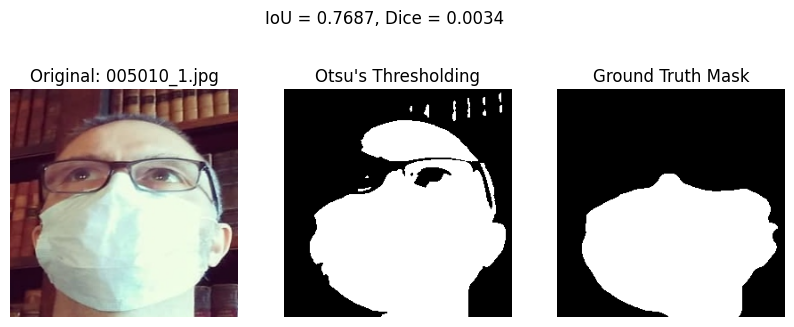

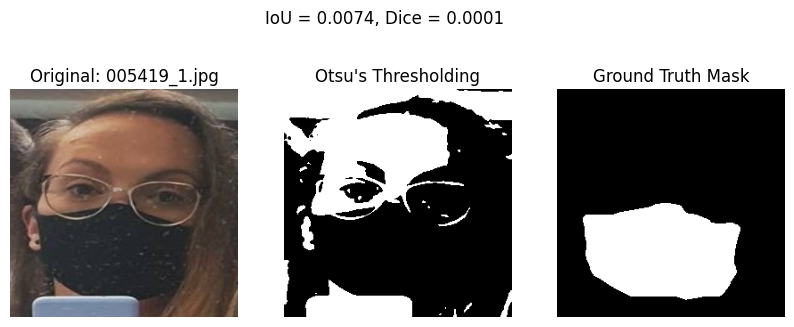

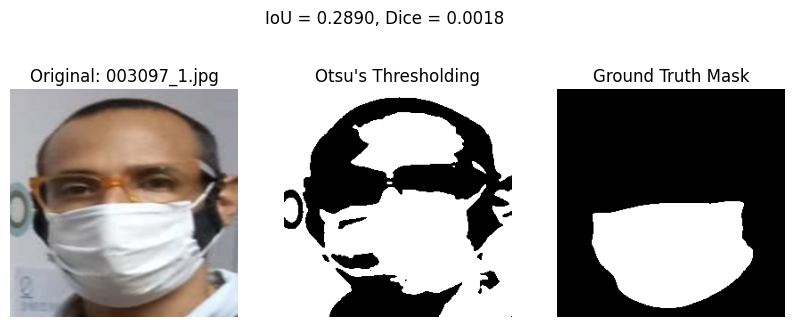

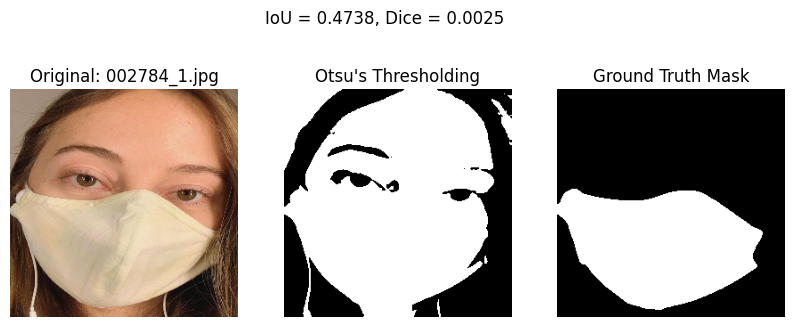

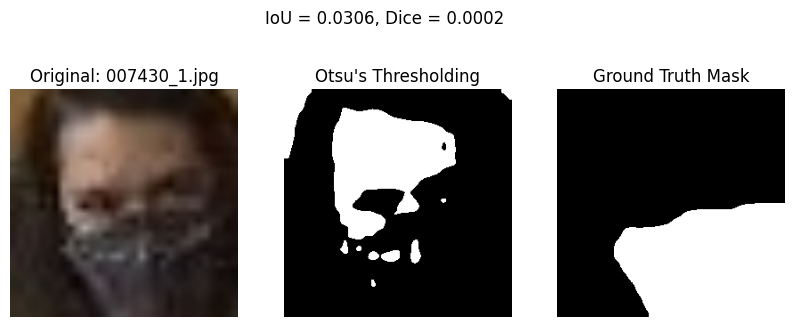

In [17]:


# Function to apply Otsu's Thresholding
def apply_otsu_threshold(image, size=(256, 256)):
    image_resized = cv2.resize(image, size)  # Resize input image
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian Blur
    _, binary_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Otsu's Thresholding
    return binary_thresh

iou_scores = []
dice_scores = []

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

for i, file_name in enumerate(image_files):
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    if not os.path.exists(mask_path):
        continue

    image = cv2.imread(image_path)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load ground truth mask in grayscale

    # Resize both masks to the same size (256x256)
    image_resized = cv2.resize(image, (256, 256))
    mask_gt = cv2.resize(mask_gt, (256, 256))

    # Ensure binary mask (0 and 255)
    _, mask_gt = cv2.threshold(mask_gt, 127, 255, cv2.THRESH_BINARY)

    # Apply Otsu's Thresholding
    mask_pred = apply_otsu_threshold(image_resized)

    # Compute IoU and Dice score
    iou = compute_iou(mask_pred, mask_gt)
    dice = compute_dice(mask_pred, mask_gt)

    iou_scores.append(iou)
    dice_scores.append(dice)

    # displaying first 5 images
    if i < 5:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {file_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("Otsu's Thresholding")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(mask_gt, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.suptitle(f"IoU = {iou:.4f}, Dice = {dice:.4f}")
        plt.show()


In [19]:
print(f"Average IoU for Otsu's Thresholding: {np.mean(iou_scores):.4f}")
print(f"Average Dice Score for Otsu's Thresholding: {np.mean(dice_scores):.4f}")

Average IoU for Otsu's Thresholding: 0.2800
Average Dice Score for Otsu's Thresholding: 0.0015


## Clustering

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x72ad389e5310>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

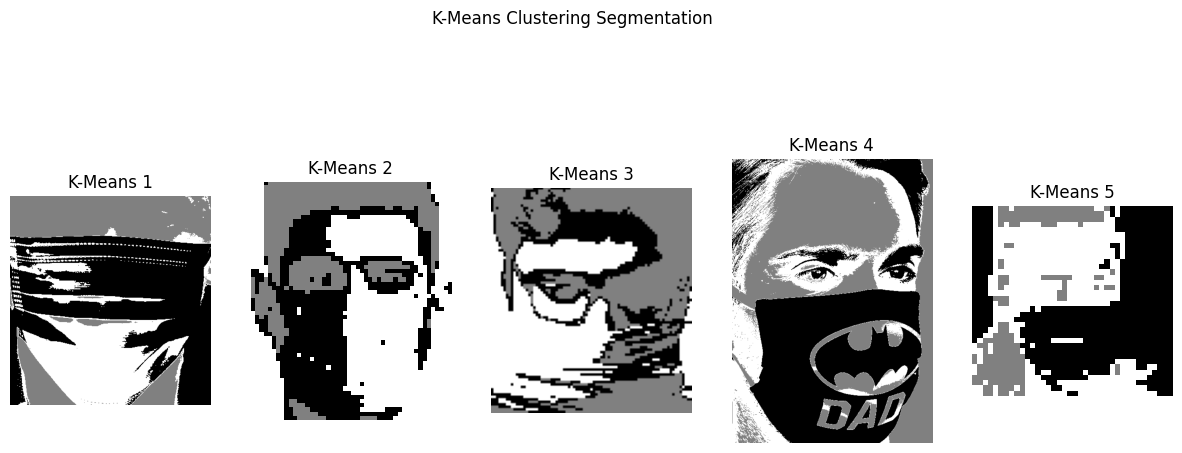

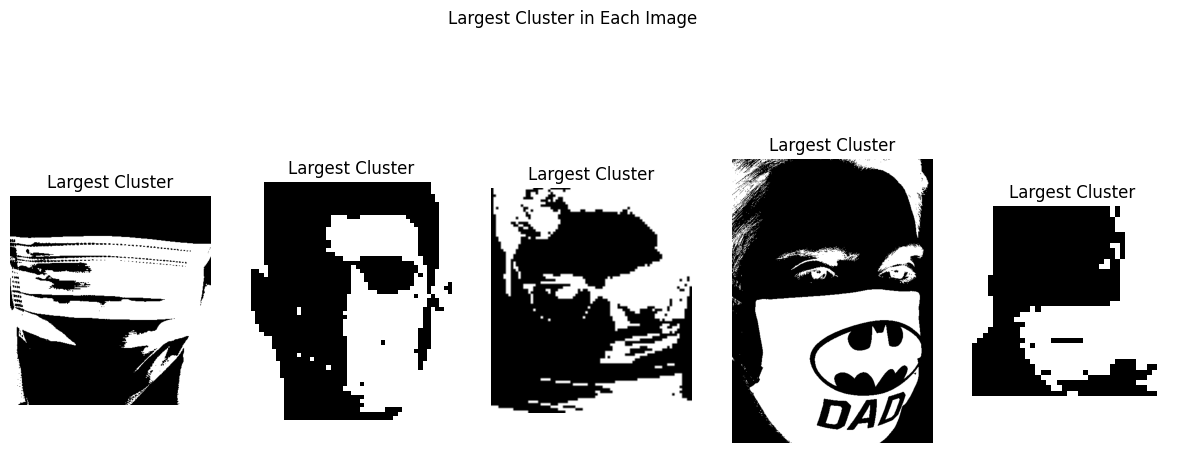

In [ ]:

plt.figure(figsize=(15, 6))

largest_masks = []

for i, image in enumerate(images):
    # Convert image to LAB color space for better clustering
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3))

    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Reshape labels to image shape
    mask_kmeans = labels.reshape(image.shape[:2])

    # Display K-Means result
    plt.subplot(1, 5, i + 1)
    plt.imshow(mask_kmeans, cmap="gray")
    plt.title(f"K-Means {i+1}")
    plt.axis("off")

    # Find the Largest Cluster
    unique, counts = np.unique(mask_kmeans, return_counts=True)
    largest_cluster = unique[np.argmax(counts)]  # Cluster with max area

    # Extract largest cluster
    largest_mask = np.uint8(mask_kmeans == largest_cluster) * 255
    largest_masks.append(largest_mask)  # Store for next plot

plt.suptitle("K-Means Clustering Segmentation")
plt.show()

plt.figure(figsize=(15, 6))
for i, largest_mask in enumerate(largest_masks):
    plt.subplot(1, 5, i + 1)
    plt.imshow(largest_mask, cmap="gray")
    plt.title(f"Largest Cluster")
    plt.axis("off")

plt.suptitle("Largest Cluster in Each Image")
plt.show()

# largest cluster appear to have parts of the mask in most images

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b416637f1f0>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

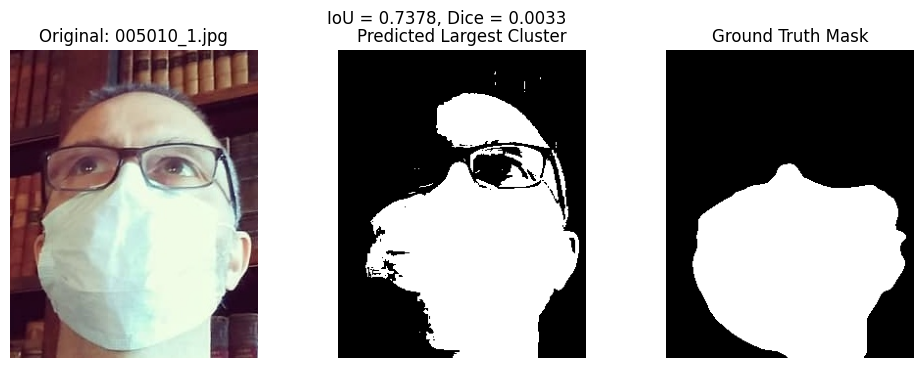

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4162373790>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

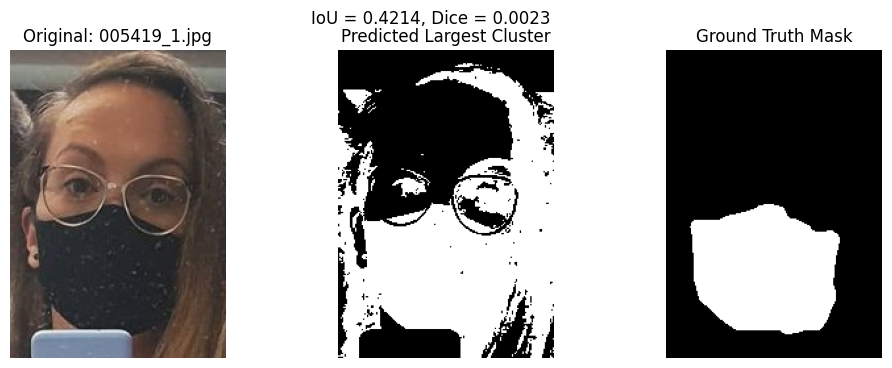

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b41622af700>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

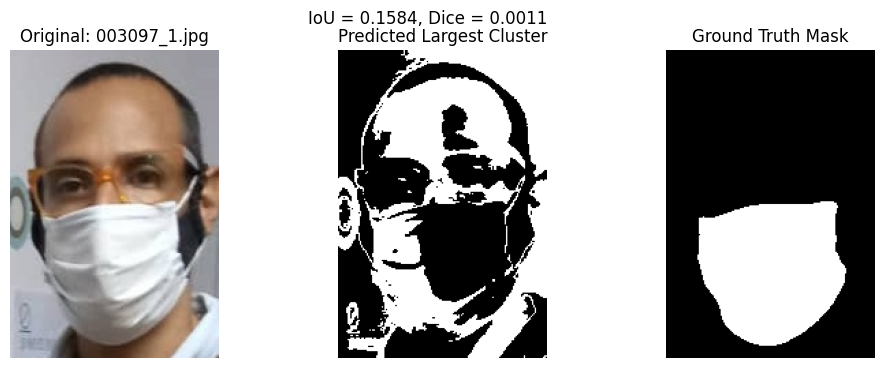

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4166b88430>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

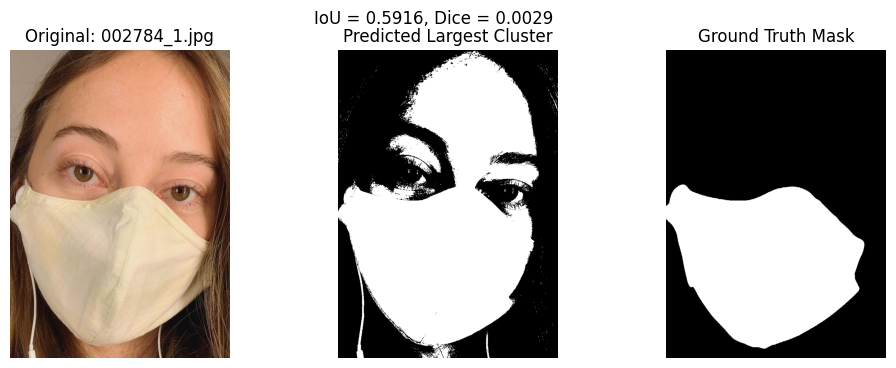

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b4166360dc0>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

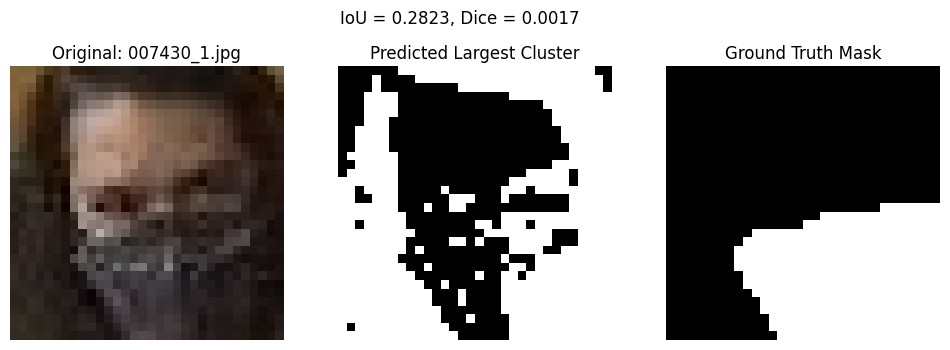

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b41662c8790>
Traceback (most recent call last):
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dyuthi/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

In [ ]:
def get_largest_cluster(image, n_clusters=3):
    # Convert to LAB for better color clustering
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)

    mask_kmeans = labels.reshape(image.shape[:2])

    # Find the largest cluster
    unique, counts = np.unique(mask_kmeans, return_counts=True)
    largest_cluster = unique[np.argmax(counts)]

    # Create binary mask for the largest cluster
    largest_mask = np.uint8(mask_kmeans == largest_cluster) * 255
    
    return largest_mask

def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    
    if union == 0:
        return 0  # Avoid division by zero
    
    return intersection / union

def compute_dice(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    total_pixels = mask_pred.sum() + mask_gt.sum()
    
    if total_pixels == 0:
        return 0  # Avoid division by zero
    
    return (2 * intersection) / total_pixels


iou_scores = []
dice_scores = []
i = 0
for file_name in os.listdir(image_dir):
    if not file_name.endswith(".jpg"):
        continue
    
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)
    
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        continue

    image = cv2.imread(image_path)
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

    # Ensure binary ground truth mask (thresholding)
    _, mask_gt = cv2.threshold(mask_gt, 127, 255, cv2.THRESH_BINARY)

    # Get the largest K-Means cluster
    mask_pred = get_largest_cluster(image, n_clusters=3)

    iou = compute_iou(mask_pred, mask_gt)
    dice = compute_dice(mask_pred, mask_gt)
    iou_scores.append(iou)
    dice_scores.append(dice)

    i += 1
    # displaying only the first 5 images
    if i <= 5:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {file_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("Predicted Largest Cluster")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(mask_gt, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.suptitle(f"IoU = {iou:.4f}, Dice = {dice:.4f}")
        plt.show()


In [6]:
mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

mean_dice = np.mean(dice_scores)
print(f"Mean dice: {mean_dice:.4f}")



Mean IoU: 0.3406
Mean dice: 0.0018


## Watershed segmentation

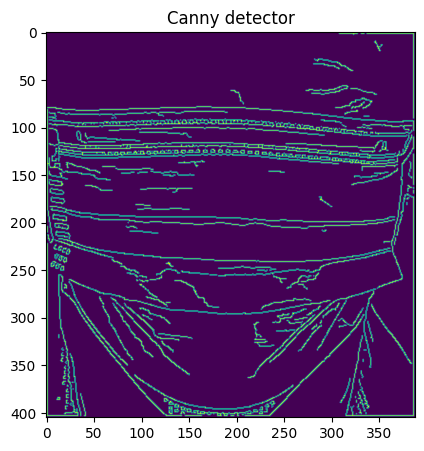

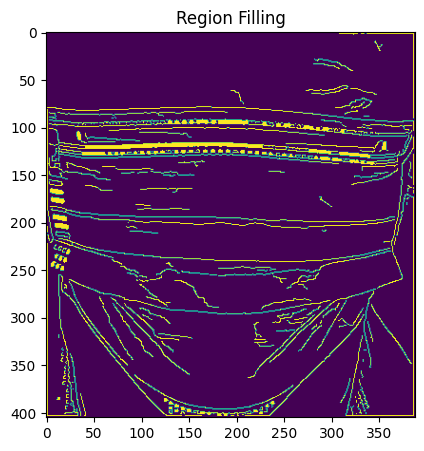

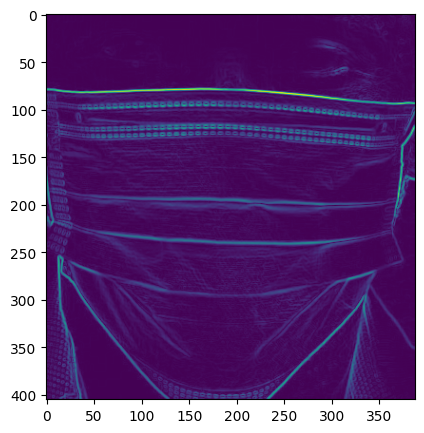

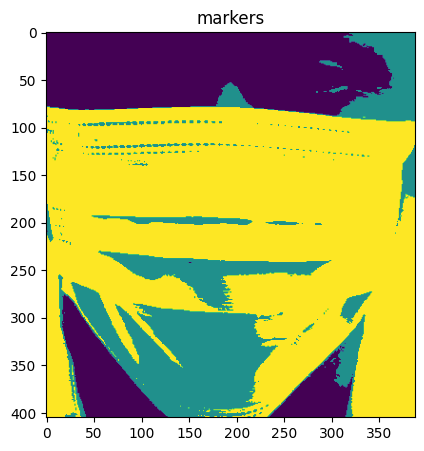

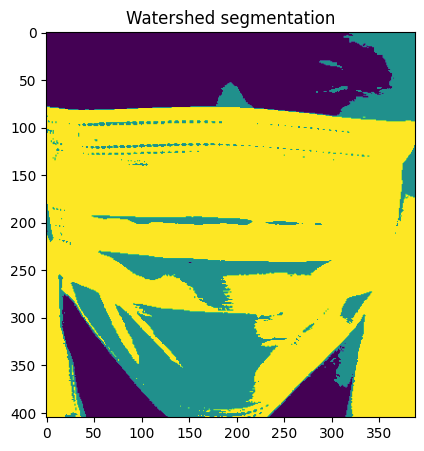

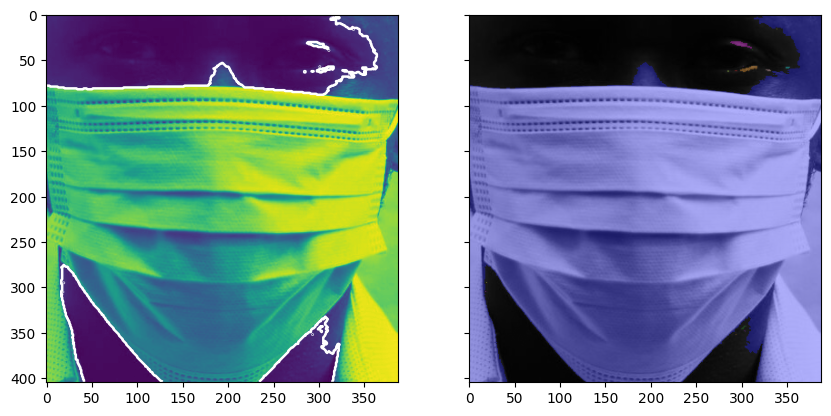

In [ ]:
plt.rcParams["figure.figsize"] = (7,5)
%matplotlib inline

image_dir = "MSFD/1/face_crop/"
file_name = "000000_1.jpg"
image_path = os.path.join(image_dir, file_name)

face_mask = cv2.imread(image_path)

face_mask_wh = rgb2gray(face_mask)

# apply edge segmentation
# plot canny edge detection
edges = canny(face_mask_wh)
plt.imshow(edges, interpolation='gaussian')
plt.title('Canny detector')
plt.show()
# fill regions to perform edge segmentation
fill_im = nd.binary_fill_holes(edges)
plt.imshow(fill_im)
plt.title('Region Filling')
plt.show()

# Region Segmentation
# First we print the elevation map
elevation_map = sobel(face_mask_wh)
plt.imshow(elevation_map)
plt.show()

# fixed thresholding
markers = np.zeros_like(face_mask_wh)
markers[face_mask_wh < 0.156862745] = 1  # 70/255
markers[(face_mask_wh >= 0.156862745) & (face_mask_wh < 0.470588235)] = 2  # 70/255 to 150/255
markers[face_mask_wh >= 0.470588235] = 3  # 150/255 and above


plt.imshow(markers)
plt.title('markers')
plt.show()

# Perform watershed region segmentation 
segmentation = watershed(elevation_map, markers)  # Use watershed from skimage.segmentation

plt.imshow(segmentation)
plt.title('Watershed segmentation')
plt.show()

# plot overlays and contour
segmentation = nd.binary_fill_holes(segmentation - 1)
label_rock, _ = nd.label(segmentation)
# overlay image with different labels
image_label_overlay = label2rgb(label_rock, image=face_mask_wh)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
ax1.imshow(face_mask_wh)
ax1.contour(segmentation, [0.8], linewidths=1.8, colors='w')
ax2.imshow(image_label_overlay)
plt.show()

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)


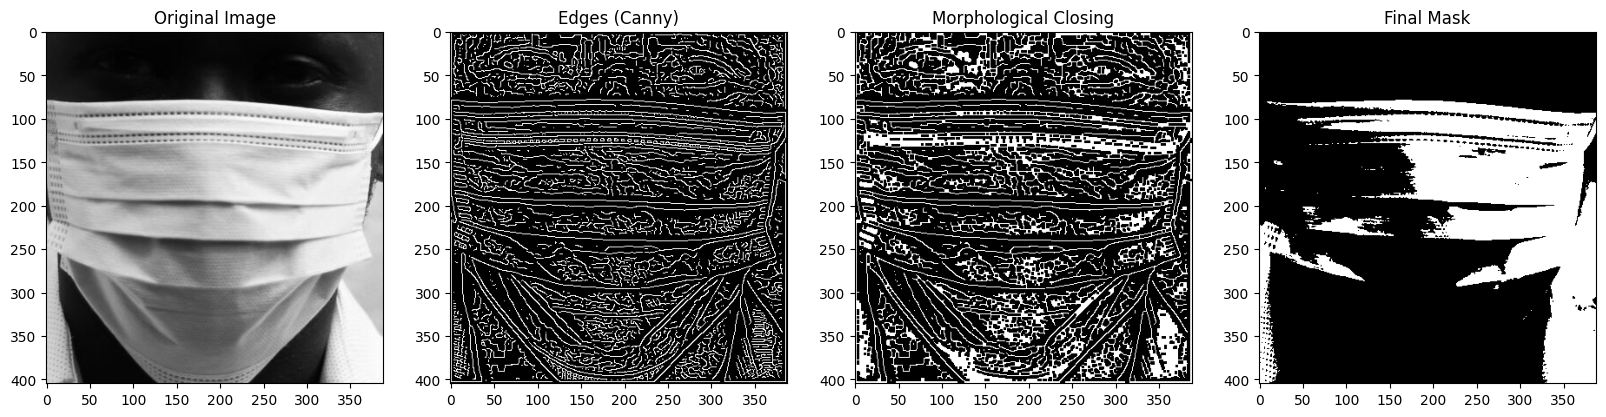

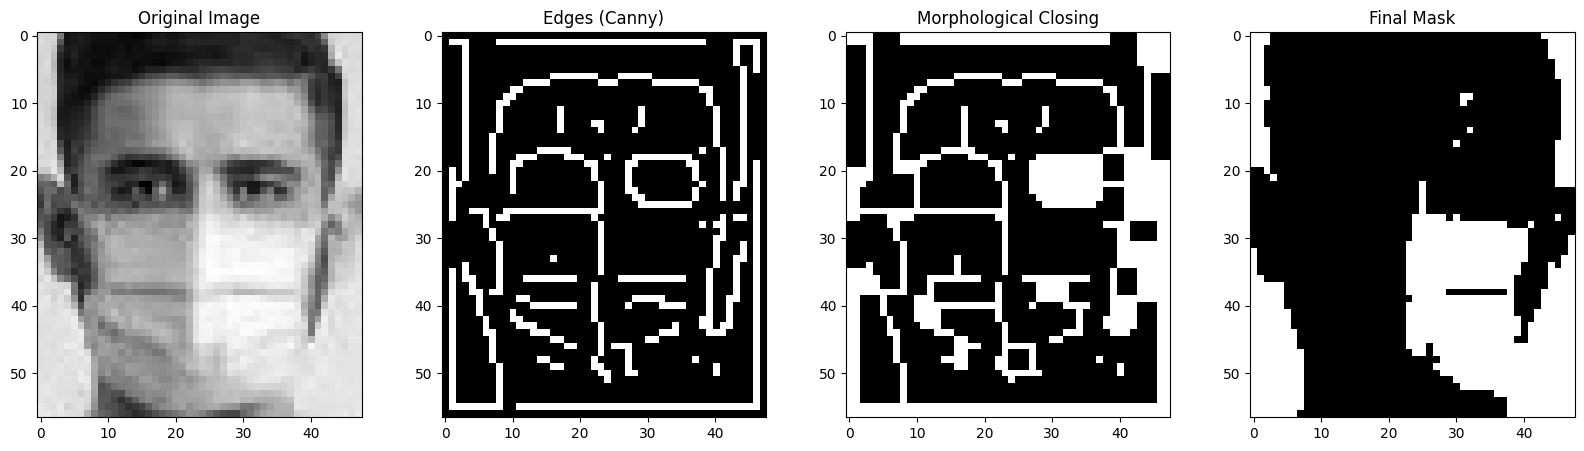

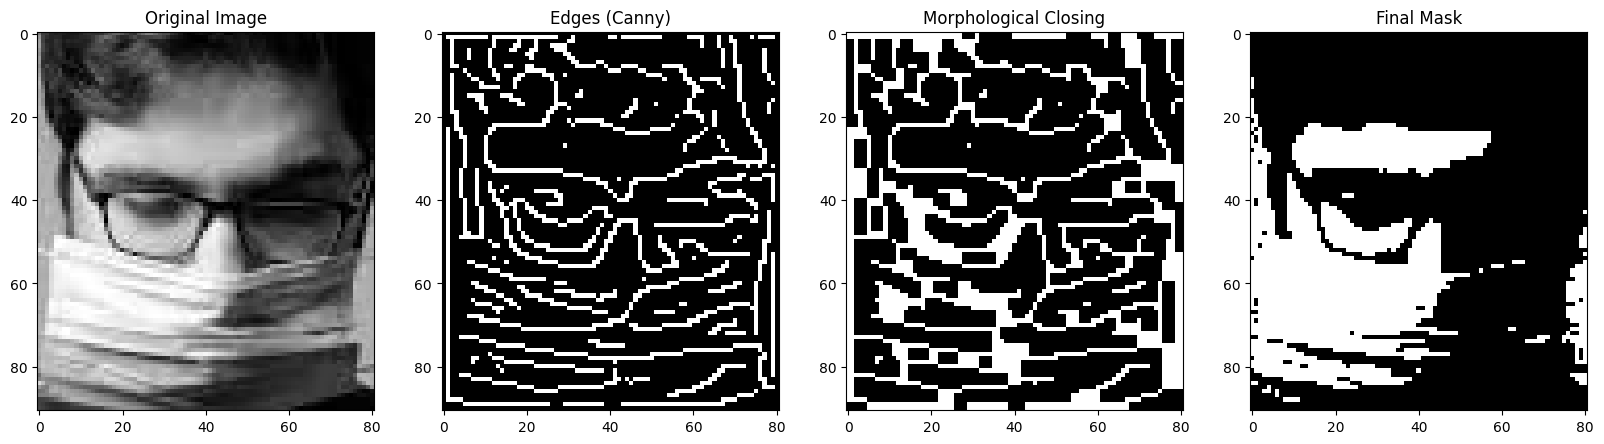

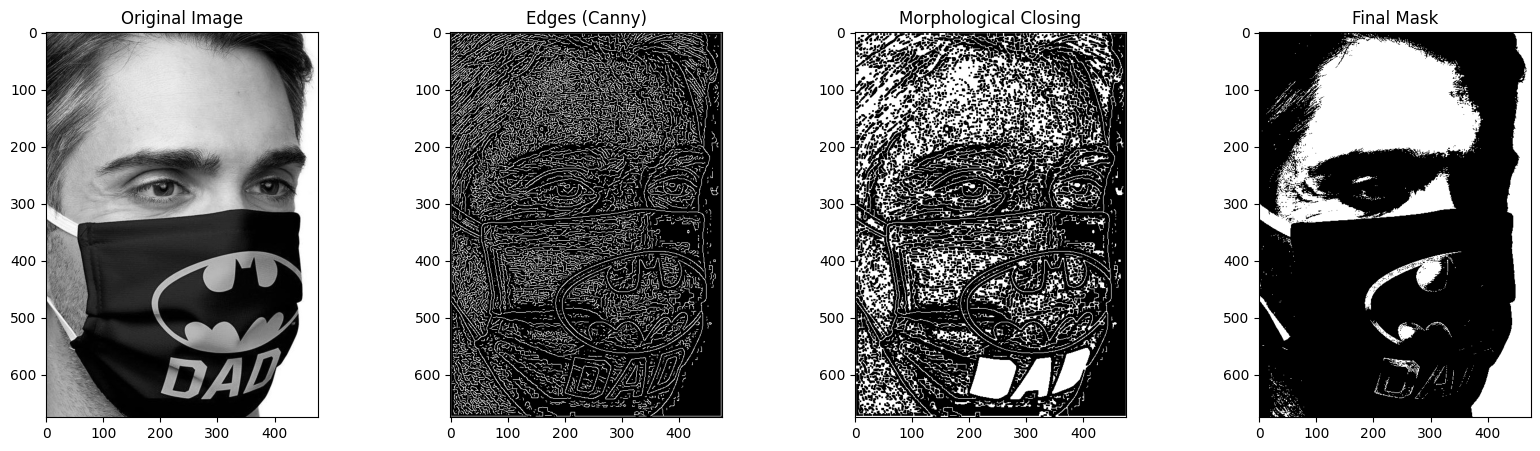

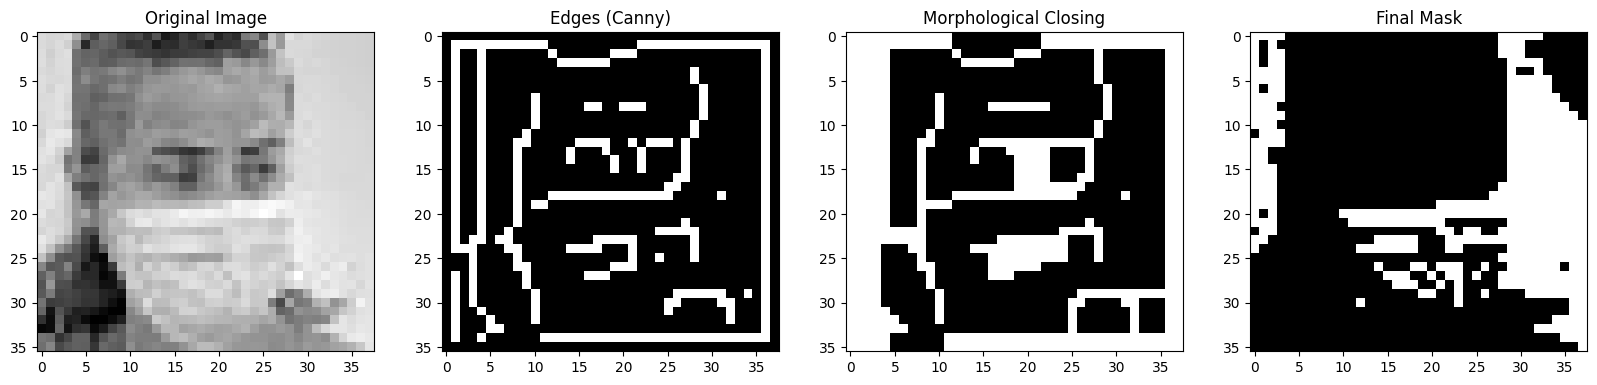

In [43]:


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


image_files = sorted(os.listdir(image_dir))

ious = []
dice_scores = [] 

for file_name in image_files:
    try:
        image_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Load Image & Ground Truth Mask
        face_mask = cv2.imread(image_path)
        face_mask_gray = rgb2gray(face_mask)
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 128  # Convert to binary mask

        # Edge Detection
        edges = canny(face_mask_gray, sigma=1.5)
        filled_regions = nd.binary_fill_holes(edges)

        # Morphological Closing (Filling small holes)
        kernel = np.ones((3, 3), np.uint8)
        closed_mask = cv2.morphologyEx(filled_regions.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

        # Elevation Map
        face_mask_blurred = nd.gaussian_filter(face_mask_gray, sigma=2)
        elevation_map = sobel(face_mask_blurred)

        # Adaptive Thresholds
        low_thresh = np.percentile(face_mask_gray, 30)
        high_thresh = np.percentile(face_mask_gray, 70)

        # Create Markers
        markers = np.zeros_like(face_mask_gray)
        markers[face_mask_gray < low_thresh] = 1
        markers[(face_mask_gray >= low_thresh) & (face_mask_gray < high_thresh)] = 2
        markers[face_mask_gray >= high_thresh] = 3  # Foreground (mask)

        # Watershed Segmentation
        segmentation = watershed(elevation_map, markers)

        # Extract Whitest Region (Mask)
        pred_mask = segmentation == segmentation.max()  # Select highest intensity region

        iou = compute_iou(pred_mask, true_mask)
        dice = compute_dice(pred_mask, true_mask)
        ious.append(iou)
        dice_scores.append(dice)

        if len(ious) == 100:
            break


        if len(ious) <= 5:
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].imshow(face_mask_gray, cmap="gray")
            axs[0].set_title("Original Image")
            axs[1].imshow(edges, cmap="gray")
            axs[1].set_title("Edges (Canny)")
            axs[2].imshow(closed_mask, cmap="gray")
            axs[2].set_title("Morphological Closing")
            axs[3].imshow(pred_mask, cmap="gray")
            axs[3].set_title("Final Mask")
            plt.show()
    except Exception:
        continue


In [45]:
print(f"Average IoU over all images: {np.mean(ious):.4f}")
print(f"Average Dice Score over all images: {np.mean(dice_scores):.4f}")


Average IoU over all images: 0.3168
Average Dice Score over all images: 0.4373


## GrabCut

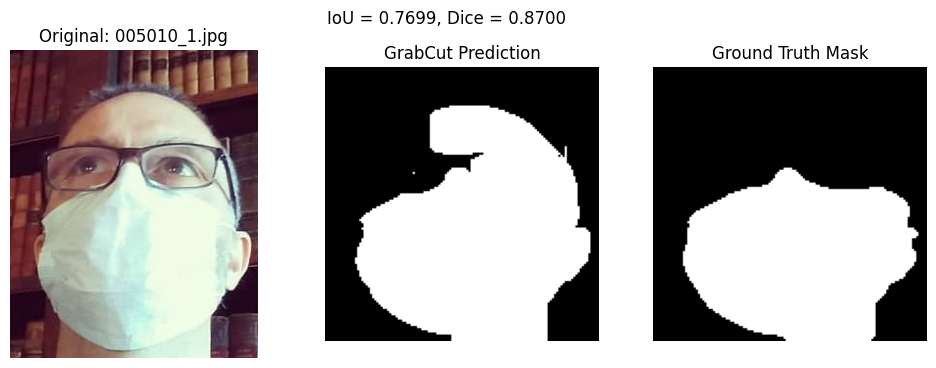

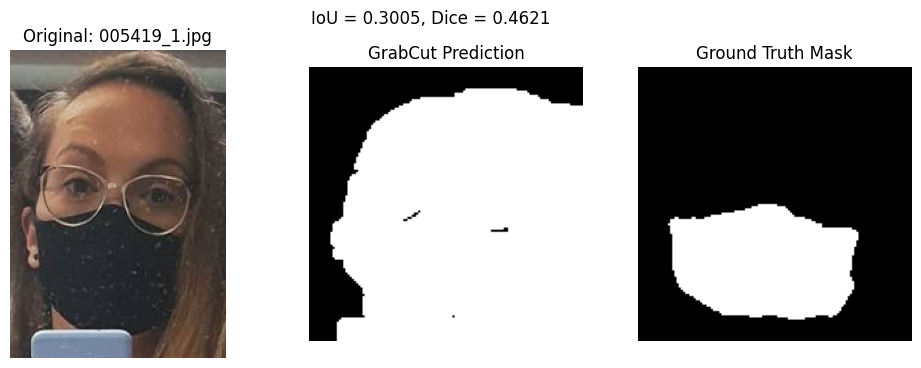

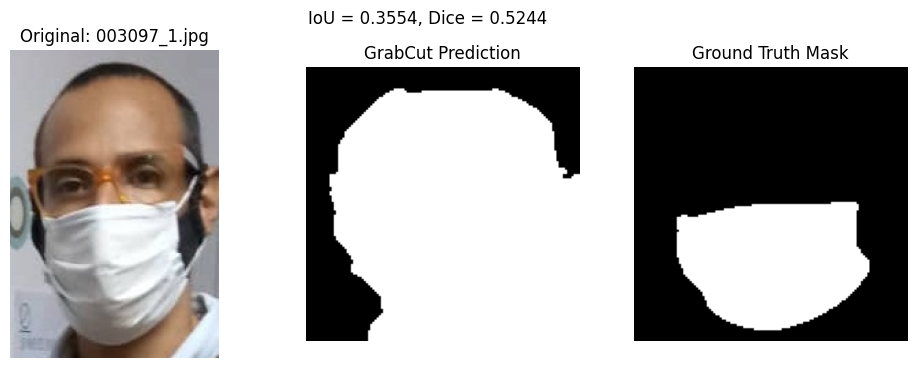

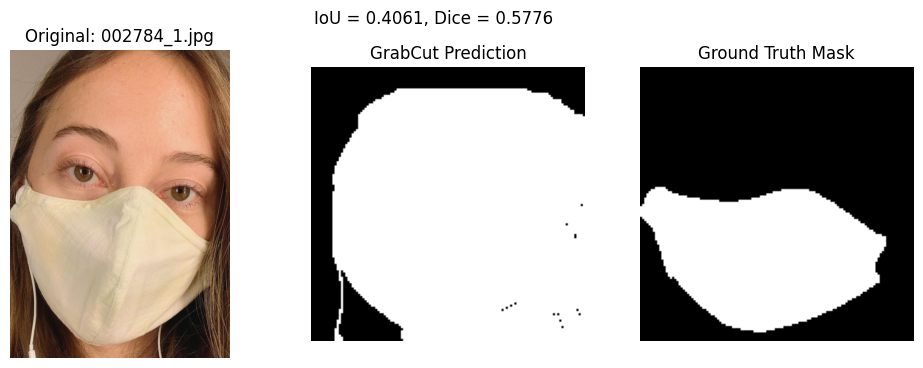

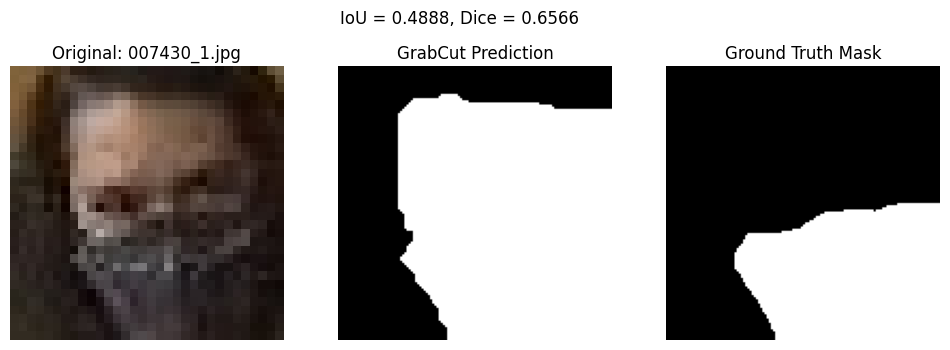

In [48]:
def apply_grabcut(image):
    img_resized = cv2.resize(image, (128, 128))  # Resize to standard dimensions
    mask_grabcut = np.zeros(img_resized.shape[:2], np.uint8)
    rect = (10, 10, 128 - 10, 128 - 10)  # bounding box
    bgd = np.zeros((1, 65), np.float64)
    fgd = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_resized, mask_grabcut, rect, bgd, fgd, 5, cv2.GC_INIT_WITH_RECT)
    grabcut_seg = np.where((mask_grabcut == 2) | (mask_grabcut == 0), 0, 255).astype(np.uint8)


    return grabcut_seg


iou_scores = []
dice_scores = []


for i, file_name in enumerate(os.listdir(image_dir)):
    if not file_name.endswith(".jpg"):
        continue
    
    image_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)

    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        continue

    image = cv2.imread(image_path)
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (128, 128))
    mask_gt = (true_mask_resized > 128).astype(np.float32)  # Binarize


    # Apply GrabCut
    mask_pred = apply_grabcut(image)
    mask_pred = (mask_pred > 128).astype(np.float32)  # Convert to binary mask

    iou = compute_iou(mask_pred, mask_gt)
    dice = compute_dice(mask_pred, mask_gt)

    iou_scores.append(iou)
    dice_scores.append(dice)
    
    if i == 50:
        break

    if i < 5:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {file_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("GrabCut Prediction")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(mask_gt, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.suptitle(f"IoU = {iou:.4f}, Dice = {dice:.4f}")
        plt.show()


In [49]:
print(f"Average IoU over all images: {np.mean(iou_scores):.4f}")
print(f"Average Dice Score over all images: {np.mean(dice_scores):.4f}")


Average IoU over all images: 0.5569
Average Dice Score over all images: 0.6968
